# <center> Purchasing your next house! </center>

### Libraries, credentials, and configuration

In [8]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
import re
from geopy.geocoders import Nominatim
import pprint
import folium
from folium.features import DivIcon
import matplotlib.pyplot as plt
from IPython.display import display

# Four Square credentials
client_id = 'PEQPJEZXPG4HRTFTMTZHL3P3QRZ1SV55525PX2YO22F3Q0JB'
client_secret = 'JEDPFGTRY4SISHI1S2W3RTQGIG3UUROA5OG4I3NW4UXBBLB1'
version = '20180605'

# OpenCage Geocoding API key
my_api_key = "a91cf6a6d9ec4e6fa91deb0bc4fbf168"

### Shortlisting the cities based on population

There are some good cities around Austin, but it will become a heavy task to compare and contrast each cities as there are more than 30. So, this project will be limited to top three cities with a high population in the list.

In [2]:
# Scraping the near-by cities list from wikipedia
austin_nearby = "https://en.wikipedia.org/wiki/Greater_Austin"
response = requests.get(austin_nearby)

# Parsing the results with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find_all("table", class_="wikitable")
population_table = table[1]
pop_def = population_table.find_all('td')

city_list = []
population_list = []

for i in range(0, 27, 3):
    city_list.append(pop_def[i].text.strip())
    population_list.append(pop_def[i+1].contents[0])

city_df = pd.DataFrame(columns=["CityName", "Population"])
city_df["CityName"] = city_list 
city_df["Population"] = population_list
city_df

CityName Population
0        Austin    950,715
1    Round Rock    123,678
2    Cedar Park     75,704
3    Georgetown     70,685
4    San Marcos     63,071
5  Pflugerville     59,245
6       Leander     42,761
7          Kyle     39,060
8         Hutto     23,832

As we see, the top three cities are: <strong>Austin, Round Rock, and Cedar Park</strong>. So, let's start exploring them


In [10]:
# Getting the latitude and longitude coordinates of these cities using OpenCage Geocoding APIs
city_list = ['Austin', 'Round Rock', 'Cedar Park']
latitude_list = []
longitude_list = []
top_city_df = pd.DataFrame(columns=["CityName", "Population", "Latitude", "Longitude"])

for city in city_list:
    query = city + ", TX, United States of America"
    uri = "https://api.opencagedata.com/geocode/v1/json?q={}&key={}".format(query, my_api_key)
    response = requests.get(uri).json()
    latitude_list.append(response['results'][0]['geometry']['lat'])
    longitude_list.append(response['results'][0]['geometry']['lng'])
    
top_city_df["CityName"] = city_list
top_city_df["Latitude"] = latitude_list
top_city_df["Population"] = city_df["Population"]
top_city_df["Longitude"] = longitude_list
    
top_city_df

CityName Population   Latitude  Longitude
0      Austin    950,715  30.271129 -97.743700
1  Round Rock    123,678  30.508235 -97.678893
2  Cedar Park     75,704  30.521712 -97.827833

### Exploring the top 3 cities with respect to various attributes

For the selected three cities, we are going to explore these different aspects which could be a good starting point to consider when purchasing a house:
<ul>
    <li>Health  [Hospital, Pharmacies, Clinics, Dentist]</li>
    <li>Food  [Grocery shops, restaurants, coffee shops]</li>
    <li>Education [Elementary schools, middle schools, high schools, college/university]</li>
    <li>Entertainment  [Movie Theaters, Bars]</li>
    <li>Number of schools with High-rating</li>
    <li>Average prices of the house</li>
    <li>Property taxes</li>
    <li>Average HOA</li>    
</ul>

I've chosen Health, Food, and Entertainment as first three categories because that's the most we'd need to be available close-by. 

FourSquare has unique ID's for different categories of venues listed here: https://developer.foursquare.com/docs/resources/categories. We are going to use this to explore various categories around three cities. These are the high-level categories that are chosen for this analysis (and their respective category_ID's can be found in the code):
<ul>
    <li> <strong>Health</strong> - medical center, details about doctor's office, ER, hospital, medical lab, physical therapist, outdoors and recreation, health and beauty services, pharmacy etc</li>
    <li> <strong>Food</strong> - all cuisine restaurants in the world, breakfast place, coffee shops, Fruits and Vegetables store etc</li>
    <li> <strong>Education</strong> - elementary, middle, and high schools, colleges, and universities</li>
    <li> <strong>Entertainment</strong> - Arts and entertainment, museum, nightlife spot, social clubs etc.</li>


In [46]:
# defining a common class to construct the request URL used to explore venues under various categories
def requestPayload(latitude, longitude, category):
    # crafting the request url
    limit = 500      # no. of locations to return
    radius = 8050    # approx 5 miles
    url = "https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&limit={}&radius={}&ll={},{}".format(category, client_id, client_secret, version, limit, radius, latitude, longitude)
    return url      


#### 1. Health 

In [39]:
# creating a category list that has the category IDs of the all venues related to health
health_list = ["4d4b7105d754a06377d81259", "4f4528bc4b90abdf24c9de85", "4bf58dd8d48988d104941735", "56aa371be4b08b9a8d573526", "54541900498ea6ccd0202697", "4bf58dd8d48988d10f951735",
              "4bf58dd8d48988d194941735", "4bf58dd8d48988d177941735", "5744ccdfe4b0c0459246b4af", "4bf58dd8d48988d177941735"]

# creating an empty dataframe to store the results
health_dataframe = pd.DataFrame(columns=["CityName", "Venue", "Latitude", "Longitude"])
venues_list = []
latitude_list = []
longitude_list = []
city_list = []

for city in range(3):
    for category in health_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            latitude_list.append(response['response']['venues'][i]['location']['lat'])
            longitude_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "CityName"])
            
health_dataframe["CityName"] = city_list
health_dataframe["Venue"] = venues_list
health_dataframe["Latitude"] = latitude_list
health_dataframe["Longitude"] = longitude_list

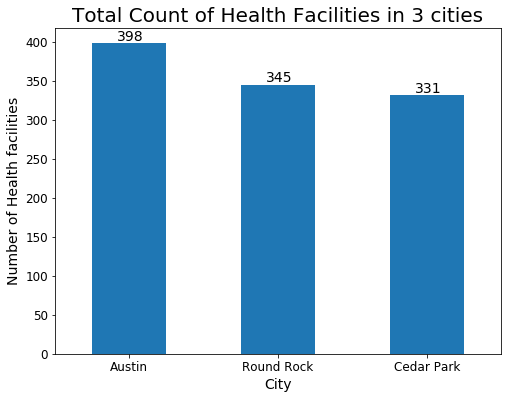

In [40]:
# plotting the health facilities in three cities for easier comparison
ax = health_dataframe['CityName'].value_counts().plot(kind='bar', figsize=(8,6), fontsize=12)
ax.set_xlabel("City", fontsize=14)
plt.xticks(rotation=0)
ax.set_ylabel("Number of Health facilities", fontsize=14)
plt.title("Total Count of Health Facilities in 3 cities", fontsize=20)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+4.0, str(i.get_height()), fontsize=14)

#### 2. Food

In [45]:
# creating a category list that has the category IDs of the all venues related to food
food_list = [
    "4d4b7105d754a06374d81259", "4bf58dd8d48988d14e941735", "4bf58dd8d48988d142941735", "4bf58dd8d48988d111941735", 
"4bf58dd8d48988d113941735", "4eb1d5724b900d56c88a45fe", "4bf58dd8d48988d1d1941735", "4bf58dd8d48988d149941735", 
"4bf58dd8d48988d1df931735", "4bf58dd8d48988d143941735", "4bf58dd8d48988d16d941735", "4bf58dd8d48988d1e0931735", 
 "4bf58dd8d48988d147941735", "4bf58dd8d48988d16e941735"]

# creating an empty dataframe to store the results
food_dataframe = pd.DataFrame(columns=["CityName", "Venue", "Latitude", "Longitude"])
venues_list = []
latitude_list = []
longitude_list = []
city_list = []

for city in range(3):
    for category in food_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            latitude_list.append(response['response']['venues'][i]['location']['lat'])
            longitude_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "CityName"])
            
food_dataframe["CityName"] = city_list
food_dataframe["Venue"] = venues_list
food_dataframe["Latitude"] = latitude_list
food_dataframe["Longitude"] = longitude_list

429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429


In [31]:
# plotting the food facilities in three cities for comparison
print(food_dataframe['CityName'].value_counts())

'''ax = food_dataframe['CityName'].value_counts().plot(kind='bar', figsize=(8,6), fontsize=12, color='red')
ax.set_xlabel("City", fontsize=14)
plt.xticks(rotation=0)
ax.set_ylabel("Total Food Locations", fontsize=14)
plt.title("Total Count of Food Facilities in 3 cities", fontsize=20)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+4.0, str(i.get_height()), fontsize=14)'''

Cedar Park    610
Austin        610
Round Rock    610
Name: CityName, dtype: int64


'ax = food_dataframe[\'CityName\'].value_counts().plot(kind=\'bar\', figsize=(8,6), fontsize=12, color=\'red\')\nax.set_xlabel("City", fontsize=14)\nplt.xticks(rotation=0)\nax.set_ylabel("Total Food Locations", fontsize=14)\nplt.title("Total Count of Food Facilities in 3 cities", fontsize=20)\n\nfor i in ax.patches:\n    ax.text(i.get_x()+.17, i.get_height()+4.0, str(i.get_height()), fontsize=14)'

In [9]:
# plotting the health facilities in three cities over maps

# creating a map that has the centre point as average of all three city's latitude and longitude
health_map = folium.Map(location=[30.433692, -97.750142], zoom_starts=11)
#health_map = folium.Map(location=[30.271129, -97.743700], min_zoom=11)


# marking Austin health facilities
for lat, long, venue in zip(health_dataframe["Latitude"], health_dataframe["Longitude"], health_dataframe["Venue"]):
    folium.CircleMarker(location=[lat, long],
    radius=8,
    popup=venue,
    color='#FF0000',
    fill=True,
    fill_color='#FF0000',
    fill_opacity=0.5).add_to(health_map)
    folium.map.Marker([30.254, -97.738],
    icon=DivIcon(
        icon_size=(500,500),
        icon_anchor=(0,0),
        html='<p style="font-size:24px;"><strong>Health Venues in 3 Cities</strong></p>',)).add_to(health_map)


display(health_map)

In [ ]:

entertainment_list = ["4bf58dd8d48988d1e4931735", "4bf58dd8d48988d17f941735", "4bf58dd8d48988d181941735", "4bf58dd8d48988d184941735", "4d4b7105d754a06376d81259", 
               "4bf58dd8d48988d11f941735"]



food_list = ["4d4b7105d754a06374d81259", "4bf58dd8d48988d14e941735", "4bf58dd8d48988d142941735", "4bf58dd8d48988d111941735", "4bf58dd8d48988d113941735", "4eb1d5724b900d56c88a45fe", 
            "4bf58dd8d48988d1d1941735", "4bf58dd8d48988d149941735", "4bf58dd8d48988d1df931735", "4bf58dd8d48988d143941735", "4bf58dd8d48988d16d941735", "4bf58dd8d48988d1e0931735", "4bf58dd8d48988d147941735", 
            "4bf58dd8d48988d16e941735"]

In [ ]:
url = "https://api.foursquare.com/v2/venues/categories?id=4bf58dd8d48988d131941735&client_id={}&client_secret={}&v={}&ll={},{}".format(client_id, client_secret, version,30.271129, -97.743700)
response = requests.get(url).json()
pprint.pprint(response)


In [4]:
# Defining a general function that will be used to consume FourSquare APIs to get details about various categories
def getCategories(latitude, longitude, query):
    num_of_venues = 100
    radius = 500
    categories_uri = "https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}".format(client_id, client_secret, version, latitude, longitude, radius, num_of_venues, query)
    return categories_uri

<center><strong>Austin, TX</strong></center>

#### i. HEALTH - that includes hospitals, pharmacies, clinic, dentists etc.

In [5]:
# Writing code to consume the above-function, and store the health responses to a dataframe
health_list = ["hospital", "pharmacy", "medical", "clinic"]
austin_health_dataframe = pd.DataFrame(columns=["Health Venue", "Latitude", "Longitude"])
venue = []
latitude = []
longitude = []
for h in health_list:
        response = requests.get(getCategories(top_city_df.loc[0, 'Latitude'], top_city_df.loc[0, 'Longitude'], h)).json()
        for i in range(len(response['response']['venues'])):
            venue.append(response['response']['venues'][i]['name'])
            latitude.append(response['response']['venues'][i]['location']['lat'])
            longitude.append(response['response']['venues'][i]['location']['lng'])

austin_health_dataframe["Health Venue"] = venue
austin_health_dataframe["Latitude"] = latitude
austin_health_dataframe["Longitude"] = longitude

austin_health_dataframe      

Health Venue   Latitude  Longitude
0                                Austin Shoe Hospital  30.269806 -97.742216
1                          Texas Hospital Association  30.274438 -97.743323
2                          Texas Hospital Association  30.274274 -97.743381
3                                        CVS pharmacy  30.267245 -97.743364
4   Brown Wharton & Brothers Medical Malpractice L...  30.268149 -97.742321
5                             Medical WasteX Disposal  30.271077 -97.743709
6                                Art Medical Alliance  30.270931 -97.741763
7                                 Texas Medical Board  30.270188 -97.746904
8                      Dell Children's Medical Center  30.267548 -97.739952
9   Texas State Board of Veterinary Medical Examiners  30.266288 -97.745539
10                      Travis County Wellness Clinic  30.273153 -97.744370
11                                       Royal clinic  30.267685 -97.744310
12                                     183 Vet Clinic  30.267153 -97.743061

In [6]:
# visualizing health venues of Austin 

# creating a map centralized to Austin
austin_map = folium.Map(location=[30.271129, -97.743700], min_zoom=15)

# marking Austin health facilities
for lat, long, venue in zip(austin_health_dataframe["Latitude"], austin_health_dataframe["Longitude"], austin_health_dataframe["Health Venue"]):
    folium.CircleMarker(location=[lat, long],
    radius=8,
    popup=venue,
    color='#FF0000',
    fill=True,
    fill_color='#FF0000',
    fill_opacity=0.5).add_to(austin_map)
    folium.map.Marker([30.254, -97.738],
    icon=DivIcon(
        icon_size=(500,500),
        icon_anchor=(0,0),
        html='<p style="font-size:24px;"><strong>Austin Health Venues</strong></p>',)).add_to(austin_map)


austin_map


#### ii. FOOD - restaurants, coffee shops, grocery stores, sandwich stores etc. 

In [14]:
food_list = ["restaurant", "coffee", "juice", "tacos", "steakhouse", "bbq", "grocery"]
austin_food_dataframe = pd.DataFrame(columns=["Food Venue", "Latitude", "Longitude"])
venue = []
latitude = []
longitude = []
for f in food_list:
        response = requests.get(getCategories(top_city_df.loc[0, 'Latitude'], top_city_df.loc[0, 'Longitude'], f)).json()
        pprint.pprint(response)
        '''for i in range(len(response['response']['venues'])):
            venue.append(response['response']['venues'][i]['name'])
            latitude.append(response['response']['venues'][i]['location']['lat'])
            longitude.append(response['response']['venues'][i]['location']['lng'])
            
austin_food_dataframe["Food Venue"] = venue
austin_food_dataframe["Latitude"] = latitude
austin_food_dataframe["Longitude"] = longitude

austin_food_dataframe'''



{'meta': {'code': 200, 'requestId': '5d30fbaf531593002c526f9f'},
 'response': {'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
                                                   'suffix': '.png'},
                                          'id': '4bf58dd8d48988d1fa931735',
                                          'name': 'Hotel',
                                          'pluralName': 'Hotels',
                                          'primary': True,
                                          'shortName': 'Hotel'}],
                          'hasPerk': False,
                          'id': '59704c261fa7632be2cede36',
                          'location': {'address': '621 Congress Ave Ste 101',
                                       'cc': 'US',
                                       'city': 'Austin',
                                       'country': 'United States',
                                       'crossStreet': '7th St',
 

{'meta': {'code': 200, 'requestId': '5d30fbafaf35f300253794f4'},
 'response': {'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
                                                   'suffix': '.png'},
                                          'id': '4bf58dd8d48988d1e0931735',
                                          'name': 'Coffee Shop',
                                          'pluralName': 'Coffee Shops',
                                          'primary': True,
                                          'shortName': 'Coffee Shop'}],
                          'hasPerk': False,
                          'id': '423a1a00f964a5202f201fe3',
                          'location': {'address': '218 W 4th St',
                                       'cc': 'US',
                                       'city': 'Austin',
                                       'country': 'United States',
                                       'crossStreet': 'a

{'meta': {'code': 200, 'requestId': '5d30fbb089b06a002c9b254e'},
 'response': {'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/juicebar_',
                                                   'suffix': '.png'},
                                          'id': '4bf58dd8d48988d112941735',
                                          'name': 'Juice Bar',
                                          'pluralName': 'Juice Bars',
                                          'primary': True,
                                          'shortName': 'Juice Bar'}],
                          'hasPerk': False,
                          'id': '50450e6be4b05fe83cc0a3de',
                          'location': {'address': '205 W 3rd St',
                                       'cc': 'US',
                                       'city': 'Austin',
                                       'country': 'United States',
                                       'crossStreet': 'Colorado'

{'meta': {'code': 200, 'requestId': '5d30fbb0be707800393480f8'},
 'response': {'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/steakhouse_',
                                                   'suffix': '.png'},
                                          'id': '4bf58dd8d48988d1cc941735',
                                          'name': 'Steakhouse',
                                          'pluralName': 'Steakhouses',
                                          'primary': True,
                                          'shortName': 'Steakhouse'}],
                          'hasPerk': False,
                          'id': '4aa06c38f964a520923f20e3',
                          'location': {'address': '114 W 7th St',
                                       'cc': 'US',
                                       'city': 'Austin',
                                       'country': 'United States',
                                       'crossStreet': 'at C

{'meta': {'code': 200, 'requestId': '5d30fbb0c0c0840025ea98d0'},
 'response': {'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
                                                   'suffix': '.png'},
                                          'id': '4bf58dd8d48988d118951735',
                                          'name': 'Grocery Store',
                                          'pluralName': 'Grocery Stores',
                                          'primary': True,
                                          'shortName': 'Grocery Store'}],
                          'hasPerk': False,
                          'id': '4d21da6dd7b0b1f7c980209f',
                          'location': {'address': '609 Congress Ave',
                                       'cc': 'US',
                                       'city': 'Austin',
                                       'country': 'United States',
                                       'cro

In [28]:
url = "https://api.foursquare.com/v2/venues/categories?id=4bf58dd8d48988d131941735&client_id={}&client_secret={}&v={}&ll={},{}".format(client_id, client_secret, version,30.271129, -97.743700)
response = requests.get(url).json()
pprint.pprint(response)



{'meta': {'code': 200, 'requestId': '5d310216d29cbb0023969860'},
 'response': {'categories': [{'categories': [{'categories': [],
                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
                                                       'suffix': '.png'},
                                              'id': '56aa371be4b08b9a8d5734db',
                                              'name': 'Amphitheater',
                                              'pluralName': 'Amphitheaters',
                                              'shortName': 'Amphitheater'},
                                             {'categories': [],
                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
                                                       'suffix': '.png'},
                                              'id': '4fceea171983d5d06c3e9823',
     

                                                                             {'categories': [],
                                                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
                                                                                       'suffix': '.png'},
                                                                              'id': '52af3aaa3cf9994f4e043bf0',
                                                                              'name': 'Fujian '
                                                                                      'Restaurant',
                                                                              'pluralName': 'Fujian '
                                                                                            'Restaurants',
                                                                              'shortName': 'Fujian'},
                            

                                                             {'categories': [{'categories': [],
                                                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/argentinian_',
                                                                                       'suffix': '.png'},
                                                                              'id': '4bf58dd8d48988d107941735',
                                                                              'name': 'Argentinian '
                                                                                      'Restaurant',
                                                                              'pluralName': 'Argentinian '
                                                                                            'Restaurants',
                                                                              'shortName': 'Argentinian'},
       

                                             {'categories': [{'categories': [],
                                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_',
                                                                       'suffix': '.png'},
                                                              'id': '52e81612bcbc57f1066b7a30',
                                                              'name': 'Nudist '
                                                                      'Beach',
                                                              'pluralName': 'Nudist '
                                                                            'Beaches',
                                                              'shortName': 'Nudist '
                                                                           'Beach'},
                                                             {'categories': [],
       

                                              'id': '4bf58dd8d48988d124941735',
                                              'name': 'Office',
                                              'pluralName': 'Offices',
                                              'shortName': 'Office'},
                                             {'categories': [],
                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/parking_',
                                                       'suffix': '.png'},
                                              'id': '4c38df4de52ce0d596b336e1',
                                              'name': 'Parking',
                                              'pluralName': 'Parking',
                                              'shortName': 'Parking'},
                                             {'categories': [],
                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories

                                                             {'categories': [],
                                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_wineshop_',
                                                                       'suffix': '.png'},
                                                              'id': '4bf58dd8d48988d119951735',
                                                              'name': 'Wine '
                                                                      'Shop',
                                                              'pluralName': 'Wine '
                                                                            'Shops',
                                                              'shortName': 'Wine '
                                                                           'Shop'}],
                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/catego

                                                              'id': '4f4531504b9074f6e4fb0102',
                                                              'name': 'Platform',
                                                              'pluralName': 'Platforms',
                                                              'shortName': 'Platform'},
                                                             {'categories': [],
                                                              'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/trainstation_',
                                                                       'suffix': '.png'},
                                                              'id': '4bf58dd8d48988d12a951735',
                                                              'name': 'Train',
                                                              'pluralName': 'Trains',
                                                              'shortNa